# MS2LDA to run on your dataset

This notebook allows all we will use **MS2LDA** to investigate a Natural Product dataset downloaded from GNPS. Our goal is to find useful substructures that can be used to identifiy unknown compounds in unknown spectra. In this example we will focus on indole based substructures, since they are widespread in natural products and therefore, they can show the potential of *MS2LDA*. <br> 
Let's dive into the script and check out all essential functionalities of *MS2LDA*.

---

First we set a working directory. Currently, MS2LDA has not setup.py file which means we cannot install it using pip and therefore we have to refer to the github repository itself. Here we want to set the working directory to the MS2LDA repository (not the MS2LDA module!).

In [1]:
import os
os.chdir("..")
print(os.getcwd())

/Users/rosinatorres/Documents/PhD/WP1/Project/Code/MS2LDA/MS2LDA


### Load modules
MS2LDA is a very flexible program and consists of many modules. In the next step we load all the modules to build our workflow. Additionally, we load rdkit, pandas and numpy for some notebook scripting.

In [2]:
from MS2LDA.Preprocessing.load_and_clean import load_mgf
from MS2LDA.Preprocessing.load_and_clean import clean_spectra

from MS2LDA.Preprocessing.generate_corpus import features_to_words
from MS2LDA.Preprocessing.generate_corpus import combine_features

from MS2LDA.modeling import define_model
from MS2LDA.modeling import train_model
from MS2LDA.modeling import extract_motifs
from MS2LDA.modeling import create_motif_spectra

from MS2LDA.Add_On.Spec2Vec.annotation import load_s2v_and_library
from MS2LDA.Add_On.Spec2Vec.annotation import calc_embeddings, calc_similarity
from MS2LDA.Add_On.Spec2Vec.annotation import get_library_matches

from MS2LDA.Add_On.Spec2Vec.annotation_refined import mask_spectra
from MS2LDA.Add_On.Spec2Vec.annotation_refined import refine_annotation

from MS2LDA.Add_On.Fingerprints.FP_annotation import annotate_motifs as calc_fingerprints

from MS2LDA.Add_On.MassQL.MassQL4MotifDB import motifs2motifDB
from MS2LDA.Add_On.MassQL.MassQL4MotifDB import motifDB2motifs

from MS2LDA.Add_On.NTS.Screening import run_screen
from MS2LDA.Add_On.NTS.Screening import save_as_csv

from MS2LDA.motif_parser import store_m2m_folder

from massql import msql_engine

import pandas as pd
import numpy as np

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import RDKFingerprint

### Workflow
The common *MS2LDA* workflow consists of 4 steps. 
- Modeling
- Annotation
- Screening
- Storing/Database
  
The next three functions are for the first 3 steps: Modeling, Annotation, and Screening.

#### Modeling
The first step is to apply *MS2LDA* to an unseen dataset to discover substructure patterns (motifs). The function combines the loading, cleaning, corpus generation and modeling and returns matchms spectrum objects for each pattern. The settings for LDA can be set according to the tomotopy documentation.

In [3]:
def generate_motifs(mgf_path, 
                    n_motifs = 50,
                    model_parameters = {
                        "rm_top": 0,
                        "min_cf": 0,
                        "min_df": 0,
                        "alpha": 0.1,
                        "eta": 0.1,
                        "seed": 42,
                    },
                    train_parameters = {
                        "parallel": 3
                    }, 
                    motif_parameter = 20,
                    charge=1,
                    motifset_name="unknown"):
    
    """generates the motif spectra based on a given mgf file
    
    ARGS:
        mgf_path (str): path to the mgf file
        model_parameters (dict): model parameters that can be set for a tomotopy LDA model
        train_parameters (dict): train parameters that can be set for a tomotopy training of an LDA model
        motif_parameter (int): number of top n most important features per motif
        
    RETURNS:
        motif_spectra (list): list of matchms spectrum objects (no precursor ion) 
    """
    # Preprocessing
    loaded_spectra = load_mgf(mgf_path)
    cleaned_spectra = clean_spectra(loaded_spectra)

    # Corpus Generation
    fragment_words, loss_words = features_to_words(cleaned_spectra)
    feature_words = combine_features(fragment_words, loss_words)

    # Modeling
    ms2lda = define_model(n_motifs=n_motifs, model_parameters=model_parameters)
    trained_ms2lda = train_model(ms2lda, feature_words, iterations=1000, train_parameters=train_parameters)

    # Motif Generation
    motifs = extract_motifs(trained_ms2lda, top_n=motif_parameter)
    motif_spectra = create_motif_spectra(motifs, charge, motifset_name)

    return motif_spectra

#### Annotation
After the generation of motifs, we want to know what the patterns could stand for. Therefore we use a retrained Spec2Vec model to find the best database matches. The assumption is that compounds with the found motif will have a higher similarity then the ones that don't. In an optimization step, it is checked that the retrieved database matches are similar in their spectra to a certain extend and that the motif contains only the fragments and losses that really represent the substructure found.

In [4]:
def annotate_motifs(top_n_matches = 5,
                    unique_mols = True,
                    path_model = "Add_On/Spec2Vec/model_positive_mode/020724_Spec2Vec_pos_CleanedLibraries.model",
                    path_library = "Add_On/Spec2Vec/model_positive_mode/positive_s2v_library.pkl"):
    """annotates motif with Spec2Vec
    
    ARGS:
        top_n_matches (int): top n compounds retrieved the database 
        unique_mols (boolean): True if only unique compounds or False duplicates can also be retrieved
        path_model (str): path to Spec2Vec model
        path_library (str): path the pkl library file, which contains embeddings, spectra and smiles
        
    RETURNS:
        optimized_motif_spectra (list): list of matchms motif spectra
        optimized_clusters (list): list of lists of spectra from clustered compounds
        smiles_clusters (list) list of lists of SMILES for clustered compounds
    """

    
    s2v_similarity, library = load_s2v_and_library(path_model, path_library)
    print("Model loaded ...")

    motif_embeddings = calc_embeddings(s2v_similarity, motif_spectra)
    similarity_matrix = calc_similarity(motif_embeddings, library.embeddings)
   
    matching_settings = {
                        "similarity_matrix": similarity_matrix,
                        "library": library,
                        "top_n": 5,
                        "unique_mols": True,
                    }

    
    library_matches = get_library_matches(matching_settings)

    masked_motif_spectra = mask_spectra(motif_spectra)
    optimized_motif_spectra, optimized_clusters, smiles_clusters, clusters_similarity = refine_annotation(s2v_similarity, library_matches, masked_motif_spectra, motif_spectra)

    return optimized_motif_spectra, optimized_clusters, smiles_clusters, clusters_similarity
    

#### Screening
When a motif is identified, we would like to use it to do a suspect screening for this substructure in a new dataset. Therefore screening can be used, which categorizes matches based on 3 criteria into 4 different groups.

In [5]:
def screen_motifs(mgf_path, optimized_motif_spectra, smiles_clusters, motif_selection=[0], save=False):
    """looks for motifs in unknown spectra"""
    loaded_spectra_to_screen = load_mgf(mgf_path)
    cleaned_spectra_to_screen = clean_spectra(loaded_spectra_to_screen)
    
    for idx, motif_smiles in zip(motif_selection, smiles_clusters):
        A,B,C,D = run_screen(optimized_motif_spectra[idx], cleaned_spectra_to_screen)
        if save == True:
            motif_smiles = motif_smiles[0]
            results = save_as_csv(A, motif_smiles)
    return A,B,C,D

### Run MS2LDA

Let's now use the functions above to discover some substructures. The GNPS-NIH-NATURALPRODUCTSLIBRARY consist of 1267 compound, which we could consider as a medium to rather large dataset. We also used MS2LDA also for very small datasets (23 compounds) and we are aiming to use it for very large dataset (entire GNPS). <br> 
Normally we would also recommand to have a look at the molecules in advance or if the dataset is to big than it can be useful to use the ERTL algorithm or the murcko scaffold to get an idea what to expect and to simply get an overview of your dataset. <br>
Since this would now extend this already long notebook, we will skip this part and move on with the modeling.

In [6]:
mgf_path_train = "test_data/msv_selected_spectra_config_1.mgf"

One of the most difficult parts is to set a number of motifs, which is mandatory. From our experience it is recommanded to set a higher ratio of motifs to compound as the number of compounds decreases. For this example we simply tried a few numbers and sticked with 62. 
- Low number of compound = relatively high amount of motifs (not exceeding the number of compound)
- high number of compound = relatively lower amount of motifs

Obviously this number actually does not depend on the number of compound but on the similarity of fragments and losses in the spectra or substructures that fragment the same way. Therefore again, check out your dataset upfront! Lately, I read a slogan on the t-shirt that fits perfectly here: Data eats models for lunch! 

> **_TIPP:_**  If you run MS2LDA the first time try to remember a few interesting motifs and look if they change if you change the number of motifs. This way you can slowly improve the modeling for your dataset.

In [7]:
%%time
#I think is important to know first the len of the dataset before setting a n_motifs, this is what I would like to do first
#from Preprocessing.load_and_clean import load_mgf
#from Preprocessing.load_and_clean import clean_spectra

#spectra = load_mgf(mgf_path_train)
#spectra = clean_spectra(spectra)
#len(spectra)

motif_spectra = generate_motifs(mgf_path_train, n_motifs=2500)

Done! Cool, on my computer the calculation of 62 motifs for 1267 compounds took below 40 seconds. Now we have 62 matchms spectrum objects, we can work with as if they would be normal spectra, only that it does not have a precursor mz or retention time. Let's plot the first motif.

Motif 0 frag mz: [108.02 123.04 150.03 151.04 152.04 284.24 312.24 407.16 408.16]
Motif 0 loss mz: [ 15.91  49.63  52.75 188.91 249.1  258.09 272.46 294.08 294.52 311.29
 327.9 ]


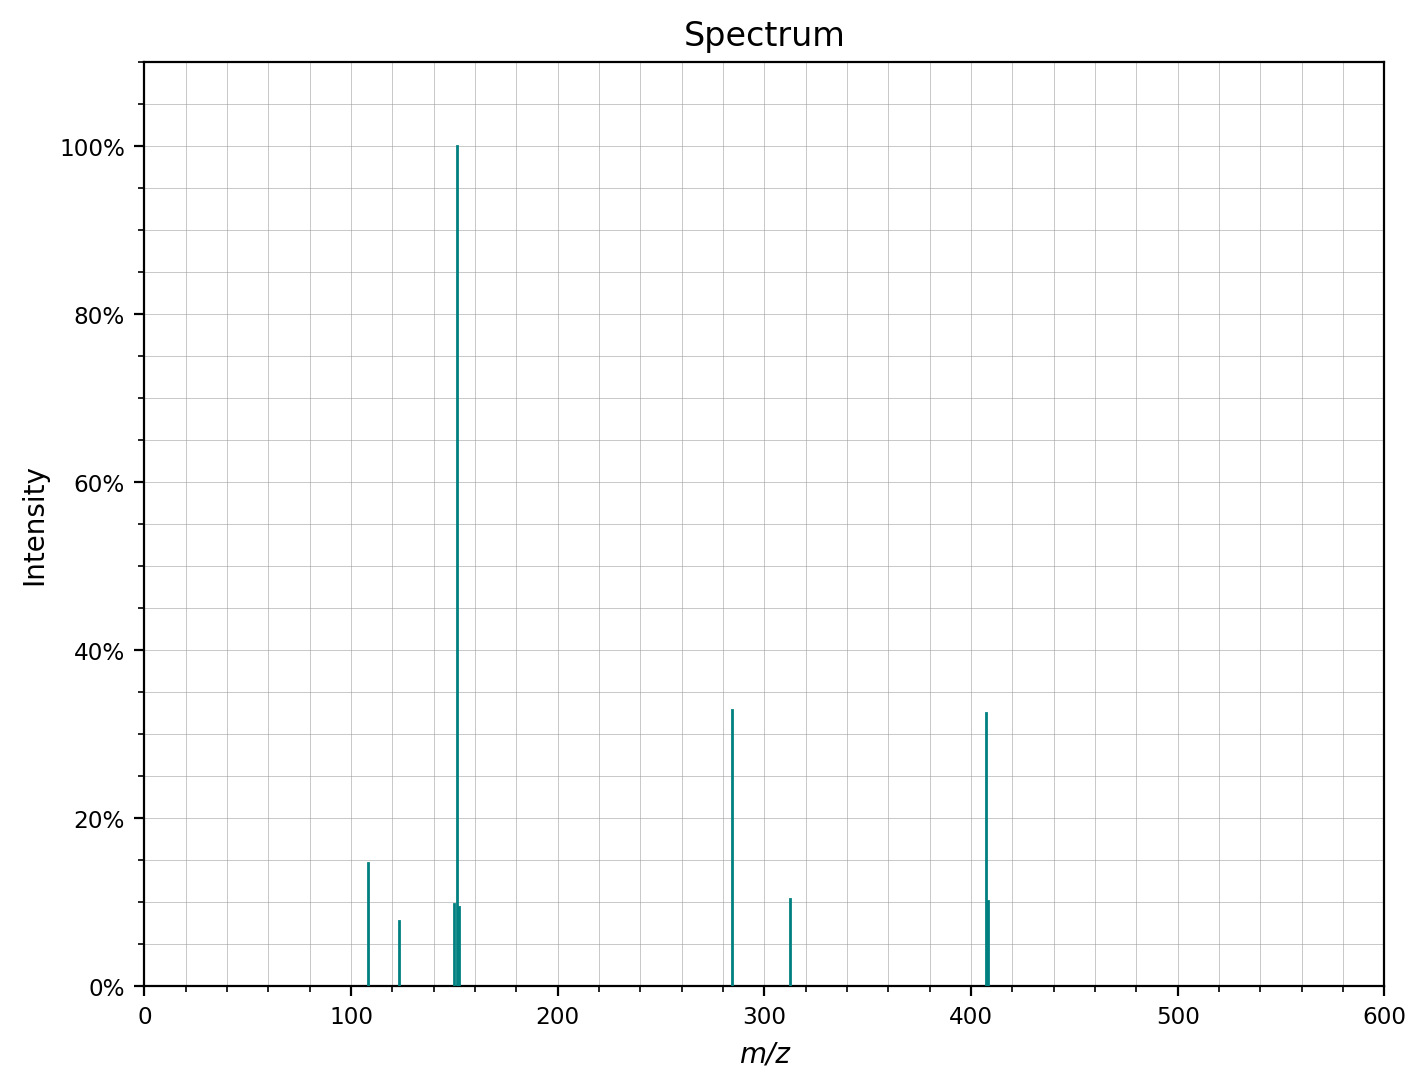

In [ ]:
motif_spectra[0].plot()
print(f"Motif 0 frag mz: {motif_spectra[0].peaks.mz}")
print(f"Motif 0 loss mz: {motif_spectra[0].losses.mz}")

It's important to remember that there is no arithmetic connection between motif fragments and losses. Losses can't be calculated based on precusor mz values since a motif does not have a precursor mz. 

We still don't know what any of the 62 motifs could mean. We could investigate every motif and try to analyze the fragments and losses to get an idea, but this would need a lot of time and probably as much expertise as well. **Let's annotate** the motifs automatically and thereby optimize the motif spectra at the same time.

In [ ]:
%%time
optimized_motif_spectra, optimized_clusters, smiles_clusters, clusters_similarity = annotate_motifs(motif_spectra)

Model loaded ...
One compound cluster!
Similarity Match:  0.9931330472103006
Only one cluster:  0.5429864253393665
One compound cluster!
Similarity Match:  0.8576576576576576
One compound cluster!
Similarity Match:  0.715702479338843
Similarity Match:  0.990990990990991
Similarity Match:  0.8371647509578545
Similarity Match:  0.8141762452107281
Similarity Match:  0.9974025974025974
Similarity Match:  0.8859504132231406
Similarity Match:  0.9974025974025974
Similarity Match:  0.9954285714285716
Similarity Match:  0.8360360360360359
Similarity Match:  0.9974025974025974
One compound cluster!
Similarity Match:  0.7298850574712644
Only one cluster:  0.24935064935064935
Only one cluster:  0.6721030042918456
Similarity Match:  0.9927927927927929
One compound cluster!
One compound cluster!
Similarity Match:  0.7567567567567568
Only one cluster:  0.3714285714285715
Similarity Match:  0.992337164750958
Only one cluster:  0.5842696629213482
Similarity Match:  0.987982832618026
Similarity Match: 

This took definitely longer! The loading of the Spec2Vec model and the database search + retrieval can take some time. For this example it is around 3 min 30 sec on my laptop.

During the optimization we see a bunch of numbers printed out in the notebook. Maybe some explanation is needed here: <br>
Since fragments in mass spectrometry are only showing the that compounds or substructures are having a similar molecular formula but not a similar substructure it can happen that a motif leads to the retrieval of compounds with completely different substructures or if no similar compound is in the database (400000 spectra are in the database, maybe 20000-30000 unique compounds) many bad and also different database matches can end up in the annotation. <br>
The algorithm tries to group the annotations based their spectral alignement with the motif. "Are the motif fragments and losses important for the database match and if so which ones". If the same fragments and losses are important for a retrieved compound we group them together. <br>
Let's go back to the numbers: <br>
The number simply says how good the overlap of the found database matches is.

> **_TIPP:_**  If a similarity is above 0.70 can be considered as a decent similarity of spectra. One compound cluster contain only one molecule, but they can also contain a good motif, but only one compound for this motif is in the database. A motif with a very low score should not be used.

Another way to estimated the goodness of a motif is to count the number of fragments and losses (features) that are still in the motif. If there is only one feature left in a motif it probably means that the annotation does not really align with the motif. There are always motifs that do not correspond to any substructure. If you are not happy with the result, maybe you can change the number of motifs. <br>
Let's plot the annotations with their corresponding motif, number of features and their cluster similarity.

In [ ]:
mols = []
legends = []
for spec, similarity in zip(optimized_motif_spectra, clusters_similarity):
    if type(similarity) == np.float64:
        similarity = round(similarity, 2)
    n_frags = len(spec.peaks.mz)
    n_losses = len(spec.losses.mz)
    n_features = n_frags + n_losses
    motif_id = spec.get("id")
    smiles_list = spec.get("short_annotation")
    for smiles in smiles_list:
        mols.append(MolFromSmiles(smiles))
        legends.append(f"{motif_id} \n {n_features} features \n similarity: {similarity}")

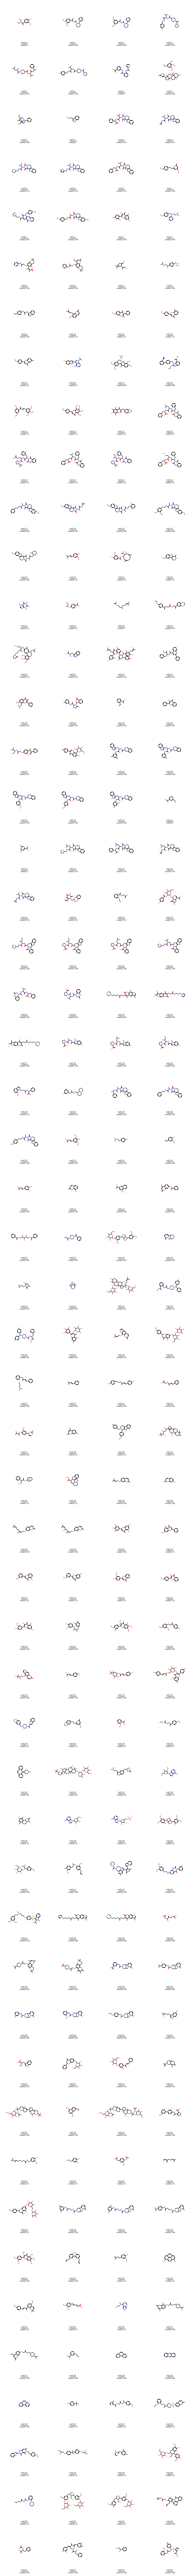

In [ ]:
MolsToGridImage(mols, molsPerRow=4, legends=legends, maxMols=222, subImgSize=(300, 300))

**This is the most important part** for finding good motifs. <br> 
First a short explanation:
- motif X is the motif id
- X features is the number of features in the optimized motif (HIGHER IS BETTER)
- similarity X is the minimum similarity of the spectra in the one cluster regarding the motif (read more in the documentation) A question mark mean that there is only one compound for this motif (HIGHER IS BETTER)

Spend some time here to find the motifs that are important for you.

> **_TIPP:_**  A motif with more than 4 or 5 features can be considered as good. It should be obvioulsy that this number depends on the size of the substructure. A smaller substructure will not have 5 common features.

Focus on the last two tipps; similarity and number of features, to find good motifs. <br>
As described at the beginning, in this notebook we are interested in indole base substructures. Therefore let's find a motif that contains an indole substructure. <br>
**Motif 60 has 3 features and a similarity of 1.0**, which means that they have a similar fragmentation pattern regarding the substructure containing indole. Let's have a closer look at the motif and use matchms functionalities for this purpose.

In [ ]:
i = 60

Motif 60 frag mz: [219.1]
Motif 60 loss mz: []


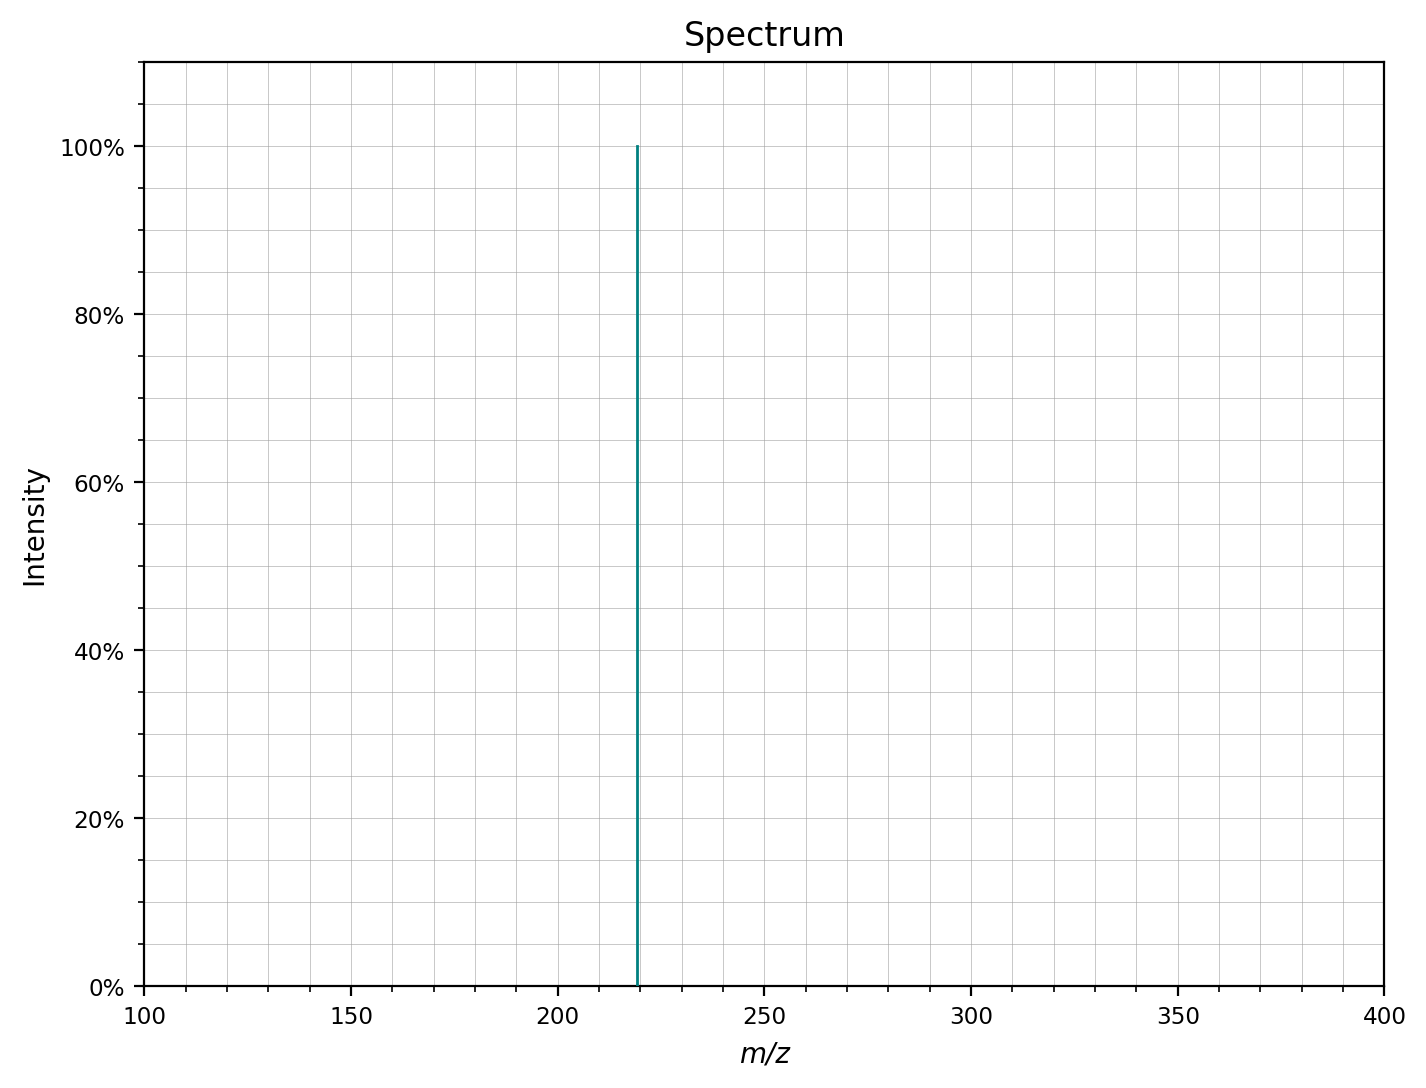

In [ ]:
optimized_motif_spectra[i].plot()
print(f"Motif {i} frag mz: {optimized_motif_spectra[i].peaks.mz}")
print(f"Motif {i} loss mz: {optimized_motif_spectra[i].losses.mz}")

We can see that we have 3 fragments and no losses for this motif. All fragments have a high importance for this motif. This does not mean that all 3 fragments need to be present in a spectrum to contain the found substructure!

If we are only interested in certain substructures and we don't want to look through all motifs manually we can calculate fingerprints for motifs that reflect the overlaping structural elements of the retrieved compounds for one motif. The threshold of 0.6 means that the substructure needs to be present in 60% of the retrieved compounds.

In [ ]:
motif_fps = calc_fingerprints(smiles_clusters, fp_type="rdkit", threshold=0.6)

[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[FP]: Executing calc_RDKIT
[

We use rdkit fingerprint for the motifs and for indole and then we check if indole is part of the motif or not. If indole is part of the substructure the score should be 1.

In [ ]:
indol = MolFromSmiles("C12=C(C=CN2)C=CC=C1")
indol_fp = np.asarray(RDKFingerprint(indol))

In [ ]:
for motif_id, (fp, similarity, spec) in enumerate(zip(motif_fps, clusters_similarity, optimized_motif_spectra)):
    if type(similarity) == np.float64:
        similarity = round(similarity, 2)
    n_frags = len(spec.peaks.mz)
    n_losses = len(spec.losses.mz)
    n_features = n_frags + n_losses
    
    overlaping_bits = 0
    for bit1, bit2 in zip(fp, indol_fp):
        if bit2 == 1 and bit1 == 1:
            overlaping_bits += 1

    overlap = round(overlaping_bits/sum(indol_fp),2)
    if overlap == 1:
        print("motif id: ", motif_id, "indol overlap: ", overlap, "similarity motif: ", similarity, "n features: ", n_features)

motif id:  5 indol overlap:  1.0 similarity motif:  ? n features:  2
motif id:  6 indol overlap:  1.0 similarity motif:  0.72 n features:  5
motif id:  14 indol overlap:  1.0 similarity motif:  0.84 n features:  5
motif id:  20 indol overlap:  1.0 similarity motif:  0.99 n features:  7
motif id:  23 indol overlap:  1.0 similarity motif:  0.76 n features:  5
motif id:  25 indol overlap:  1.0 similarity motif:  0.99 n features:  4
motif id:  28 indol overlap:  1.0 similarity motif:  0.85 n features:  2
motif id:  30 indol overlap:  1.0 similarity motif:  0.96 n features:  7


We can see that 6 motifs contain indole structures as part of the substructure. Next to our selected motif 60, motif 20 and motif 49 are looking really promising. For simplicifation reasons we wil still focus on our motif 60.

> **_TIPP:_** Fingerprints can surely be used like shown here, but another great application would be to train a machine learning models to predict properties of motifs and thereby sort motifs with a desired property. The property should be highly dependent on substructures.

## Save your results in a .m2m format (similar to mgf)

If you are happy with the results from the modeling you can store the result in a folder in .m2m format. This is the format of the former MS2LDA/MotifDB program. This format looks similar to a mgf format but it contains losses and fragments. The folder name should not already exist.

In [ ]:
non_existing_folder_name = "notebooks/NP\ with\ Indole"
store_m2m_folder(motif_spectra, non_existing_folder_name)

True

## Save your results in local MotifDB

Our prefered way to store found motifs in MS2LDA is a dataframe format based on the MassQL format. Therefore you need to download the MassQueryLanguage4Motifs repository go in the repository directory and install the package via ```pip install .```. Massql should not already be installed. <br> 
The big advantage of using the MassQL format is that we can use MassQL to query the MotifDB database. The dataframes of different experiments can simply be combined with ```pd.concatenate()```.

In [ ]:
motif_DB_ms1, motif_DB_ms2 = motifs2motifDB(optimized_motif_spectra)

motif_DB_ms1 is not of our interest since motifs only have MS2 information, but without changing the entire MassQL script we still need generate it and also use it as input. Let's query our generated MotifDB for two fragments from motif 60.

In [ ]:
input_query = "QUERY scaninfo(MS2DATA) WHERE MS2MZ=116.05:TOLERANCEMZ=0.005 AND MS2MZ=118.06:TOLERANCEMZ=0.005"
results_peaks = msql_engine.process_query(input_query, "", ms1_df=motif_DB_ms1, ms2_df=motif_DB_ms2)
results_peaks

TOTAL QUERIES 1


100%|██████████| 1/1 [00:00<00:00, 69.95it/s]


""


We can see that only motif_60 has fragment 116.05 and fragment 118.06 at the same time.

## Search for patterns in motifDB

We already stored the existing MotifDB from the MS2LDA.org version in the MassQL dataframe format and now we can import the MotifDB with pandas and query MotifDB for the same fragments as above;

In [ ]:
motif_DB_ms1 = pd.read_feather("MotifDB/MotifDB_MS1.feather")
motif_DB_ms2 = pd.read_feather("MotifDB/MotifDB_MS2.feather")

In [ ]:
input_query = "QUERY scaninfo(MS2DATA) WHERE MS2MZ=116.05:TOLERANCEMZ=0.005 AND MS2MZ=118.06:TOLERANCEMZ=0.005"
results_peaks = msql_engine.process_query(input_query, "", ms1_df=motif_DB_ms1, ms2_df=motif_DB_ms2)
results_peaks

TOTAL QUERIES 1


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


,motifset,motif_id,short_annotation,ms1scan,charge,i,mslevel
0,MIADB_pos_60,motif_13,Corynanthean_skeleton,0,1,5.008007,2
1,MIADB_pos_100,motif_7,Corynanthean_skeleton,0,1,2.425962,2


We can see that two motifsets show a match. Both annotations are Corynanthean_skeleton and according to this paper (https://www.researchgate.net/publication/341932327_Corynanthean-Epicatechin_Flavoalkaloids_from_Corynanthe_pachyceras) they would include indole substructures.

## Retrieve motif spectra from MotifDB

Since MotifDB is a dataframe, every pandas dataframe operation can be applied to optimize you own workflow. In the next step we will convert the dataframe results back to motif spectra. If you only to have motifs from one motifset or a certain charge or annotation you can build filters with the ```loc``` function for example.

In [ ]:
retrieved_motif_spectra = motifDB2motifs(motif_DB_ms2, results_peaks)

KeyError: 'scan'

In [ ]:
retrieved_motif_spectra

[Spectrum(precursor m/z=0.00, 113 fragments between 103.0 and 686.3),
 Spectrum(precursor m/z=0.00, 67 fragments between 101.0 and 297.2)]

Now we have retrived the 2 matches from MotifDB. Let's check out how the motif looks like by plotting it.

Motif 1 frag mz: [101.04 103.05 104.05 105.07 108.08 110.1  111.08 115.05 116.05 116.06
 117.06 117.06 117.07 118.06 118.07 119.08 127.05 128.05 128.06 129.06
 130.06 131.07 132.08 133.05 133.07 136.11 142.06 143.07 144.08 144.19
 145.08 146.06 154.06 154.12 155.07 155.12 156.08 158.09 159.07 160.07
 161.08 166.07 166.12 167.07 168.08 169.08 170.06 172.07 174.09 180.08
 181.08 182.09 183.07 184.07 193.09 194.09 195.1  196.07 196.11 204.08
 208.11 209.11 210.09 222.09 225.14 236.11 297.2 ]
Motif 1 loss mz: [ 72.06  76.08  77.09  78.1   79.1   88.08  89.09  90.1   91.1   92.11
  93.12 101.09 102.1  103.1  104.11 105.12 114.1  115.1  116.11 117.12
 127.1  128.11 129.12 130.12 130.13 139.1  140.11 141.12 142.13 143.07
 143.08 143.13 147.07 151.11 152.11 153.01 153.12 154.12 154.13 155.13
 159.07 159.13 161.09 165.12 166.13 167.13 168.13 169.14 170.12 170.14
 171.13 179.13 180.13 180.13 180.14 181.11 181.14 182.12 182.14 183.13
 186.14 194.14 195.13 196.13 196.16 197.14 198.14]


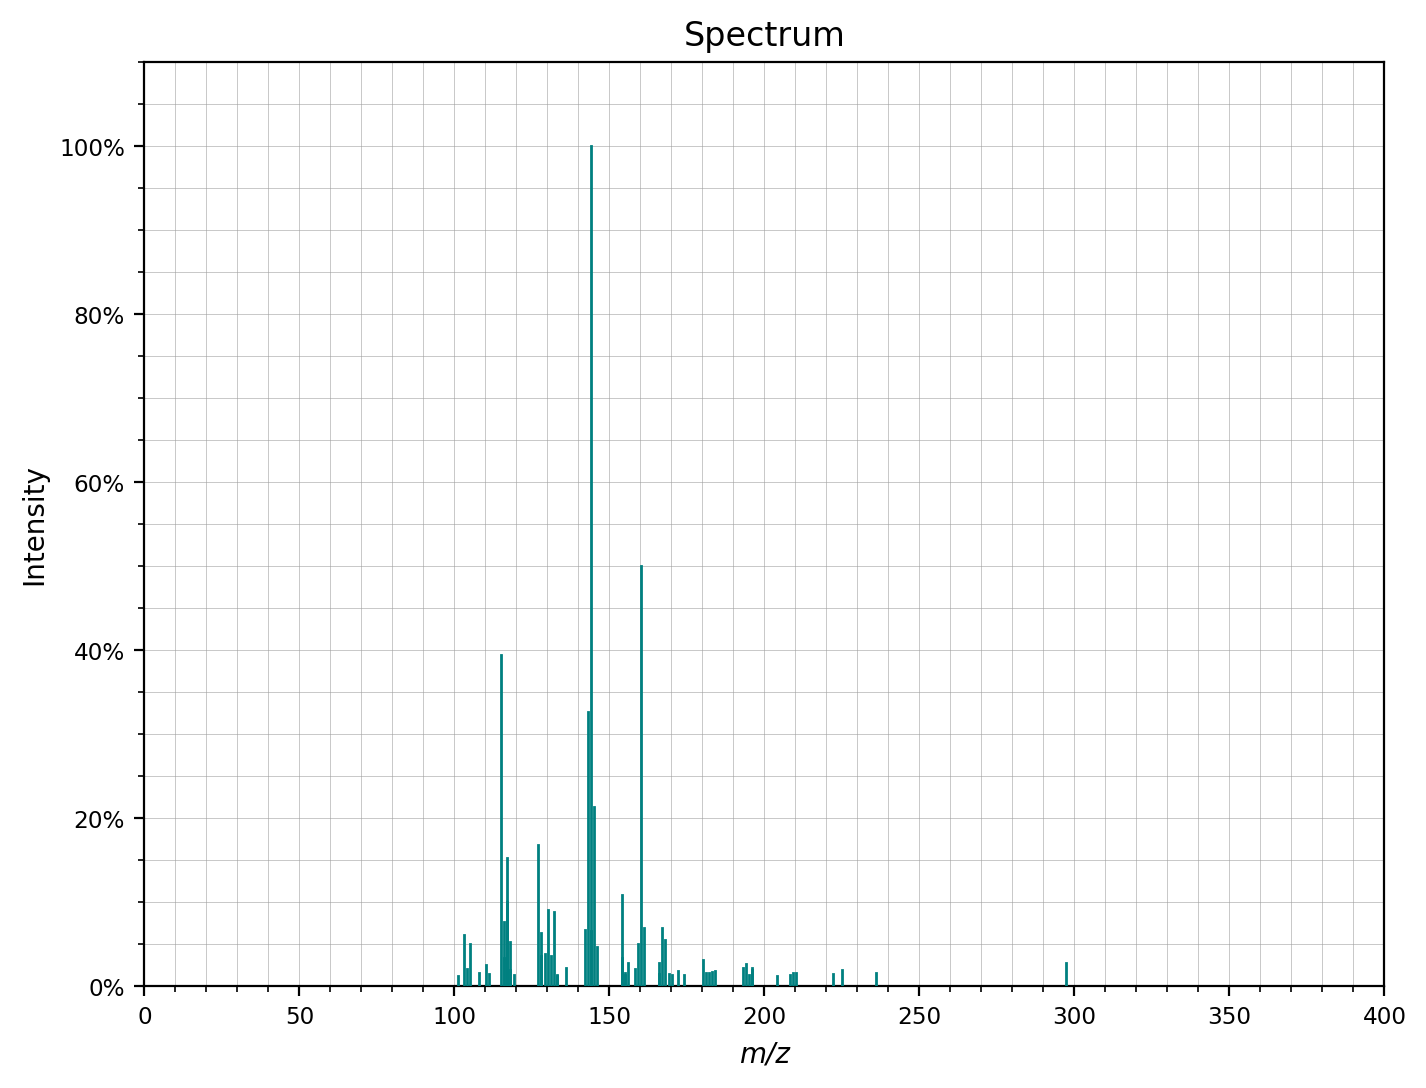

In [ ]:
retrieved_motif_spectra[1].plot()
print(f"Motif 1 frag mz: {retrieved_motif_spectra[1].peaks.mz}")
print(f"Motif 1 loss mz: {retrieved_motif_spectra[1].losses.mz}")

## Screening

Now, since we found a motif corresponding to indole and also queried and found results on MotifDB we want to use this motif to screen against a unknown database. We downloaded a GNPS library that should contain indole substructures.

In [ ]:
mgf_path_screen = "test_data/ECG-ACYL-AMIDES-C4-C24-LIBRARY.mgf"
A,B,C,D = screen_motifs(mgf_path_screen, optimized_motif_spectra, smiles_clusters, motif_selection=[60])

In [ ]:
f"matches in A: {len(A)}, matches in B:, {len(B)}, matches in C:, {len(C)}, matches in D:, {len(D)}"

'matches in A: 0, matches in B:, 1, matches in C:, 0, matches in D:, 55'

A - D are different classes that represent different confidence in motif matches with A being the highest confidence. You can read more about it in the documentation. <br>
For motif 60 we see no matches at level A and 1 match at level B. Let's see the compound found in at level B.

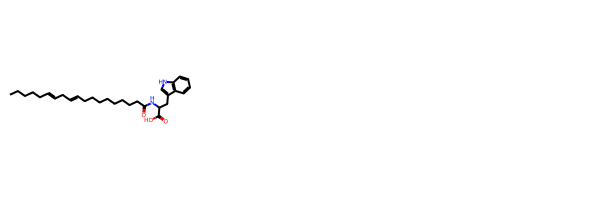

In [ ]:
MolsToGridImage([MolFromSmiles(B[0].get("smiles"))])

Let's also see what matches were found in category D.

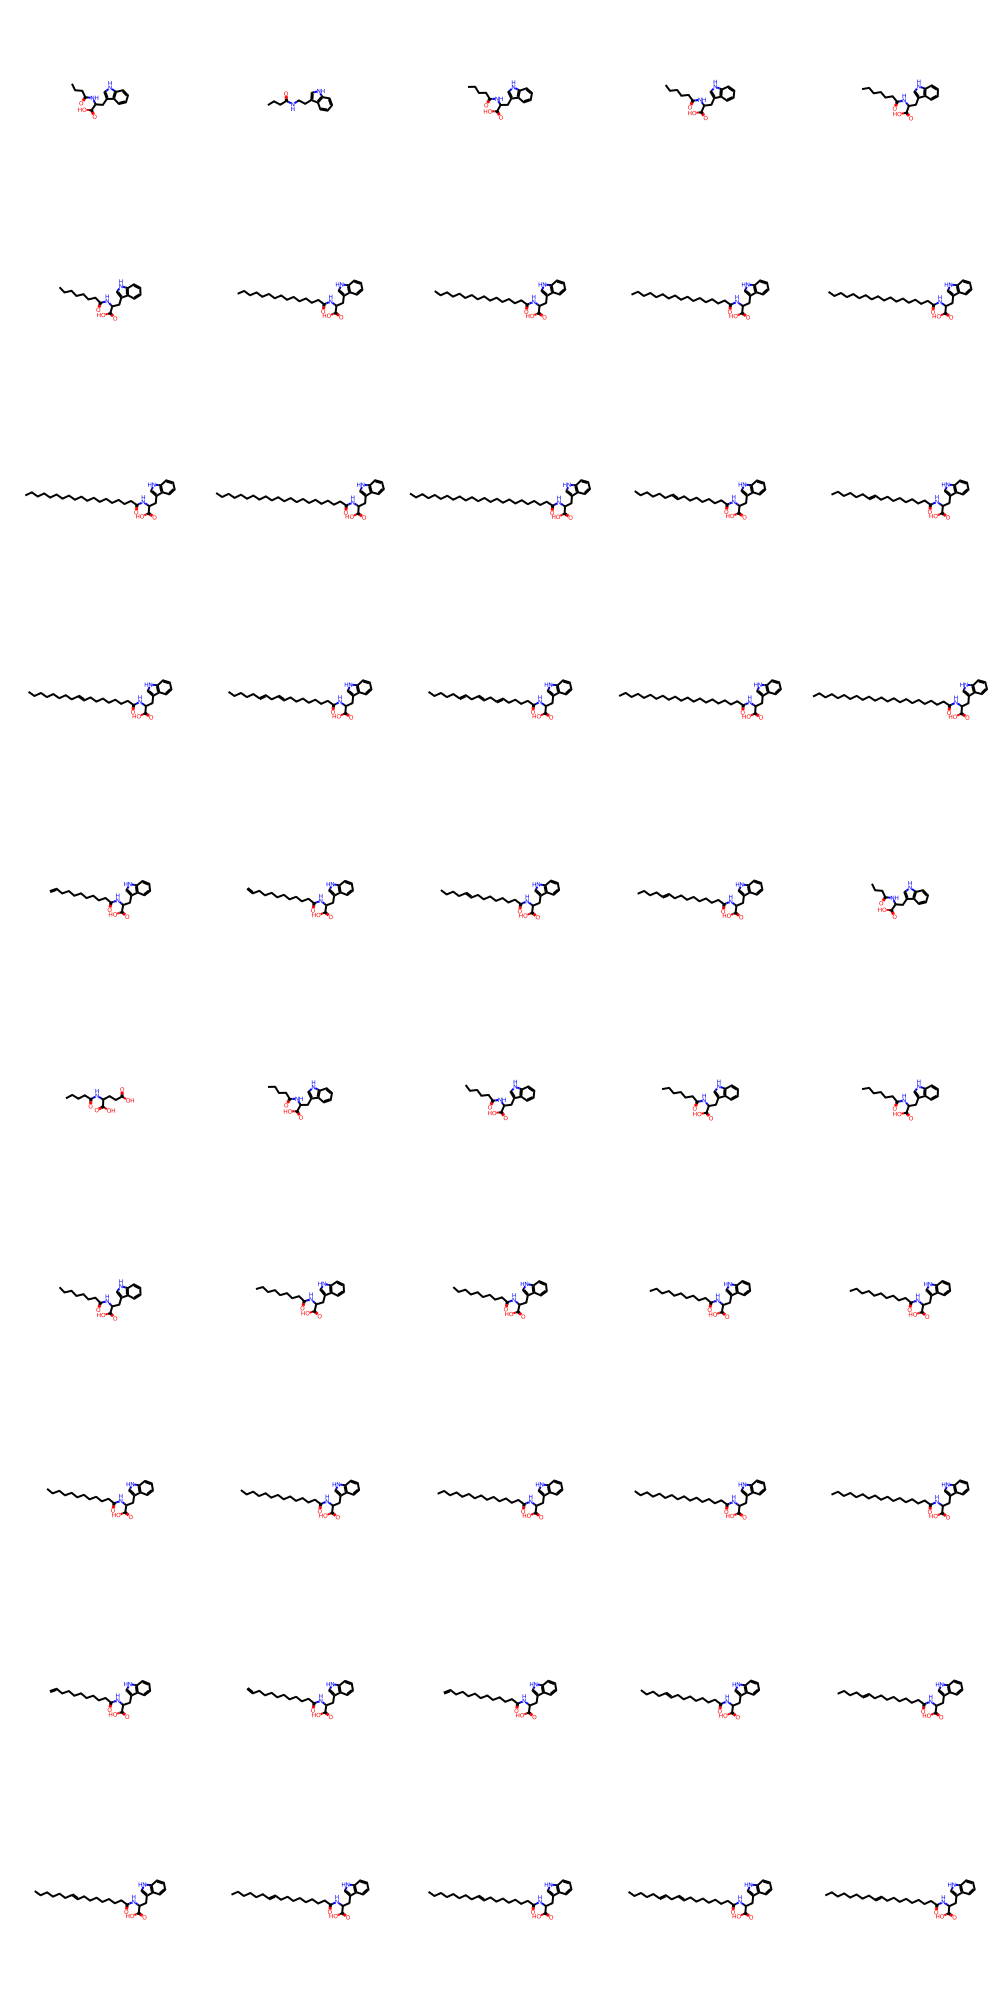

In [ ]:
MolsToGridImage([MolFromSmiles(D[k].get("smiles")) for k in range(len(D))], molsPerRow=5)

We see that even level D show nearly always good matches. Level D relies only on 1 feature and therefore should be valued to much for complex substructures, but one of the fragments seemed to be very specific for indole.

We can also use one of the MotifDB retrieved compounds for the screening.

In [ ]:
A,B,C,D = screen_motifs(mgf_path_screen, retrieved_motif_spectra, ["empty"], motif_selection=[0])

In [ ]:
f"matches in A: {len(A)}, matches in B:, {len(B)}, matches in C:, {len(C)}, matches in D:, {len(D)}"

'matches in A: 114, matches in B:, 3, matches in C:, 102, matches in D:, 180'

We can already see that way more compounds were found in all levels. This is due to large number of fragments and losses in this motif. This can also lead to false positive assignments, since it has a higher chance of spectral overlap than an optimized motif.

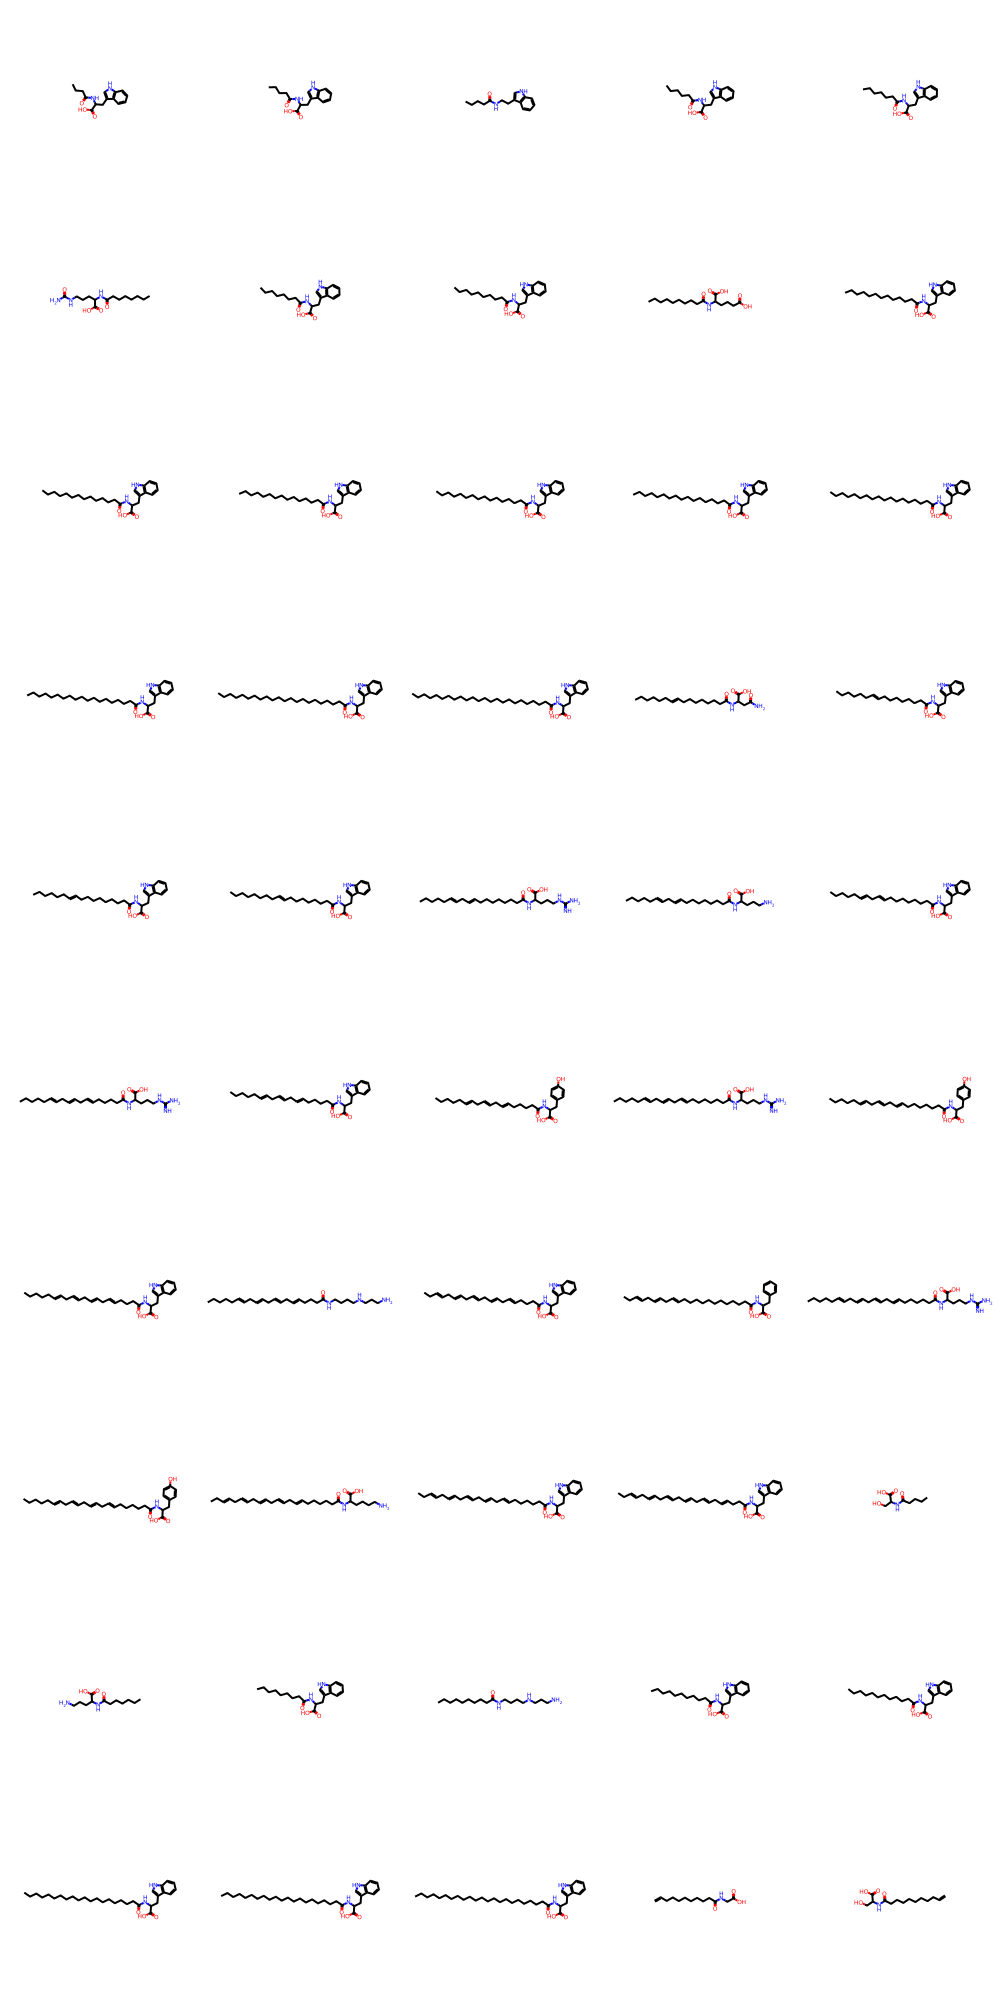

In [ ]:
MolsToGridImage([MolFromSmiles(D[k].get("smiles")) for k in range(len(A))], molsPerRow=5)

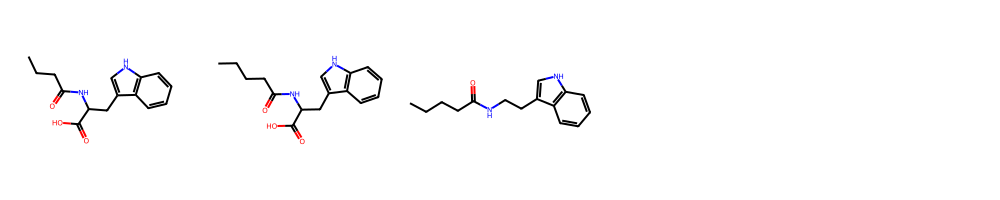

In [ ]:
MolsToGridImage([MolFromSmiles(D[k].get("smiles")) for k in range(len(B))], molsPerRow=5)

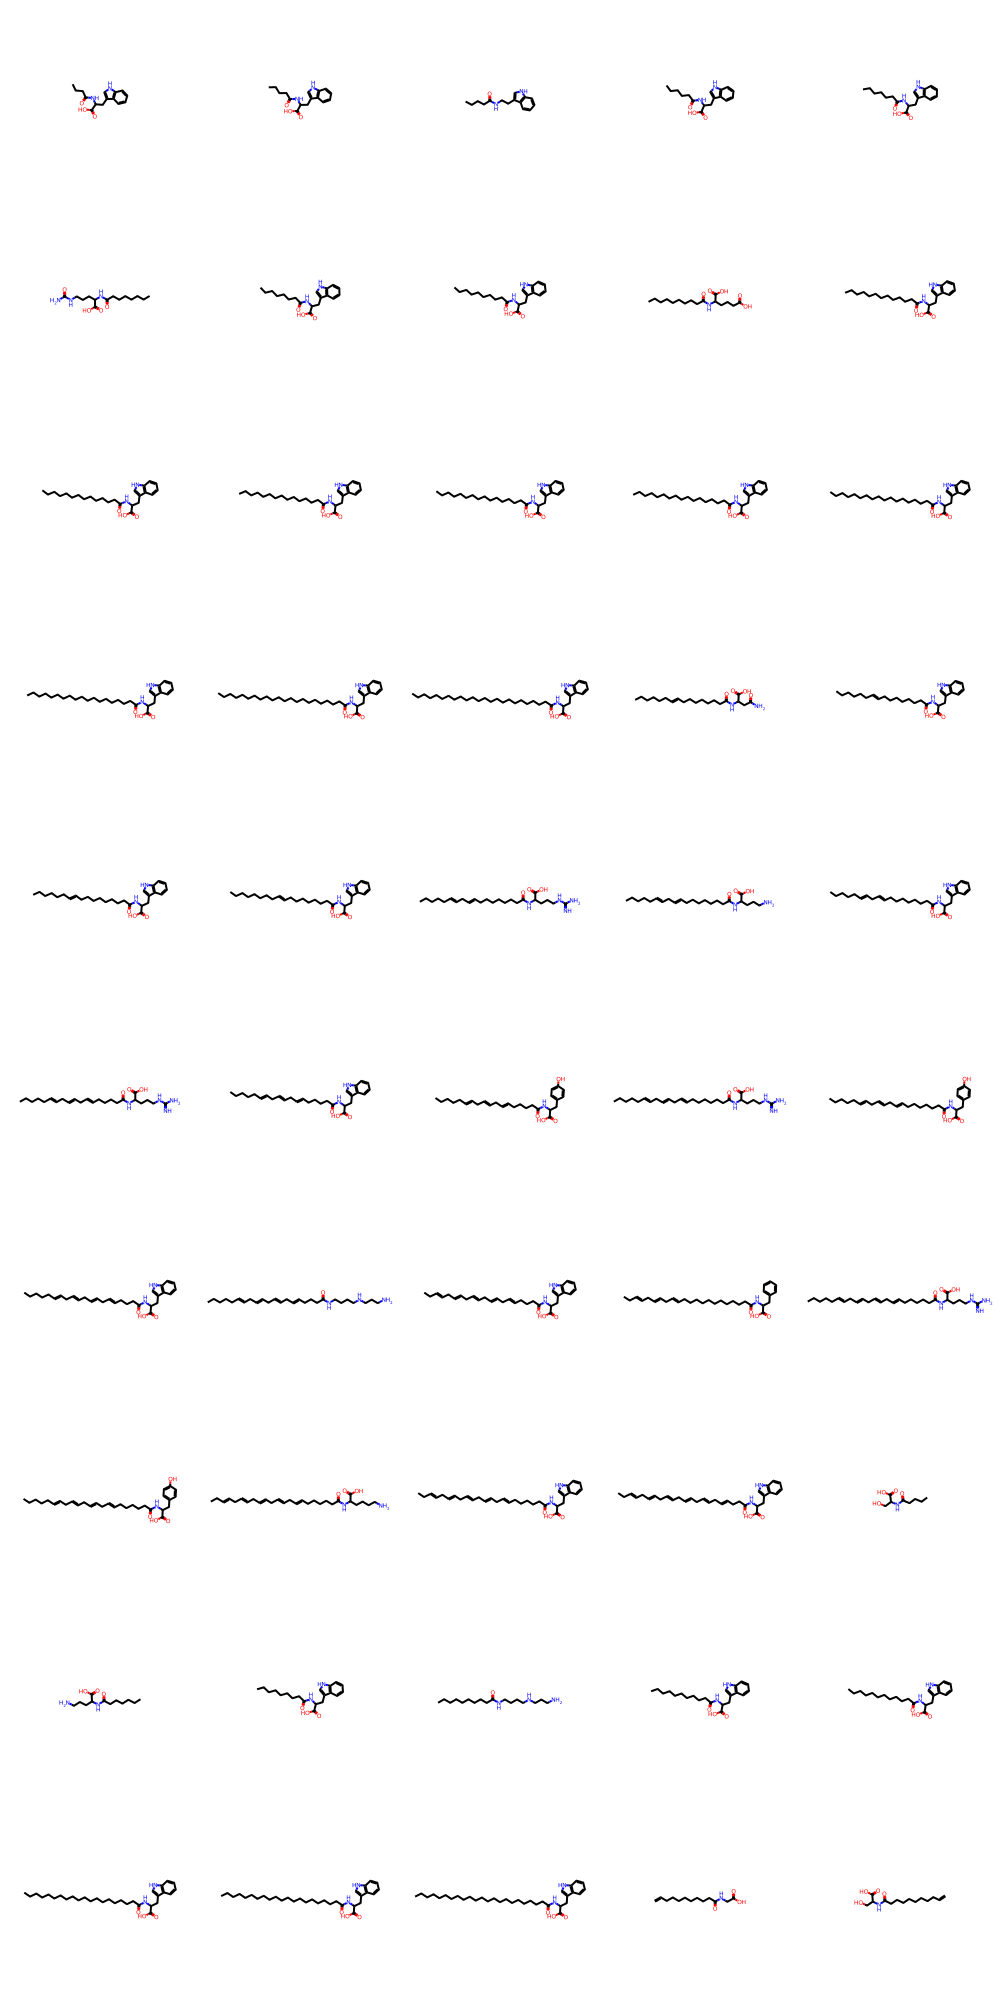

In [ ]:
MolsToGridImage([MolFromSmiles(D[k].get("smiles")) for k in range(len(C))], molsPerRow=5)

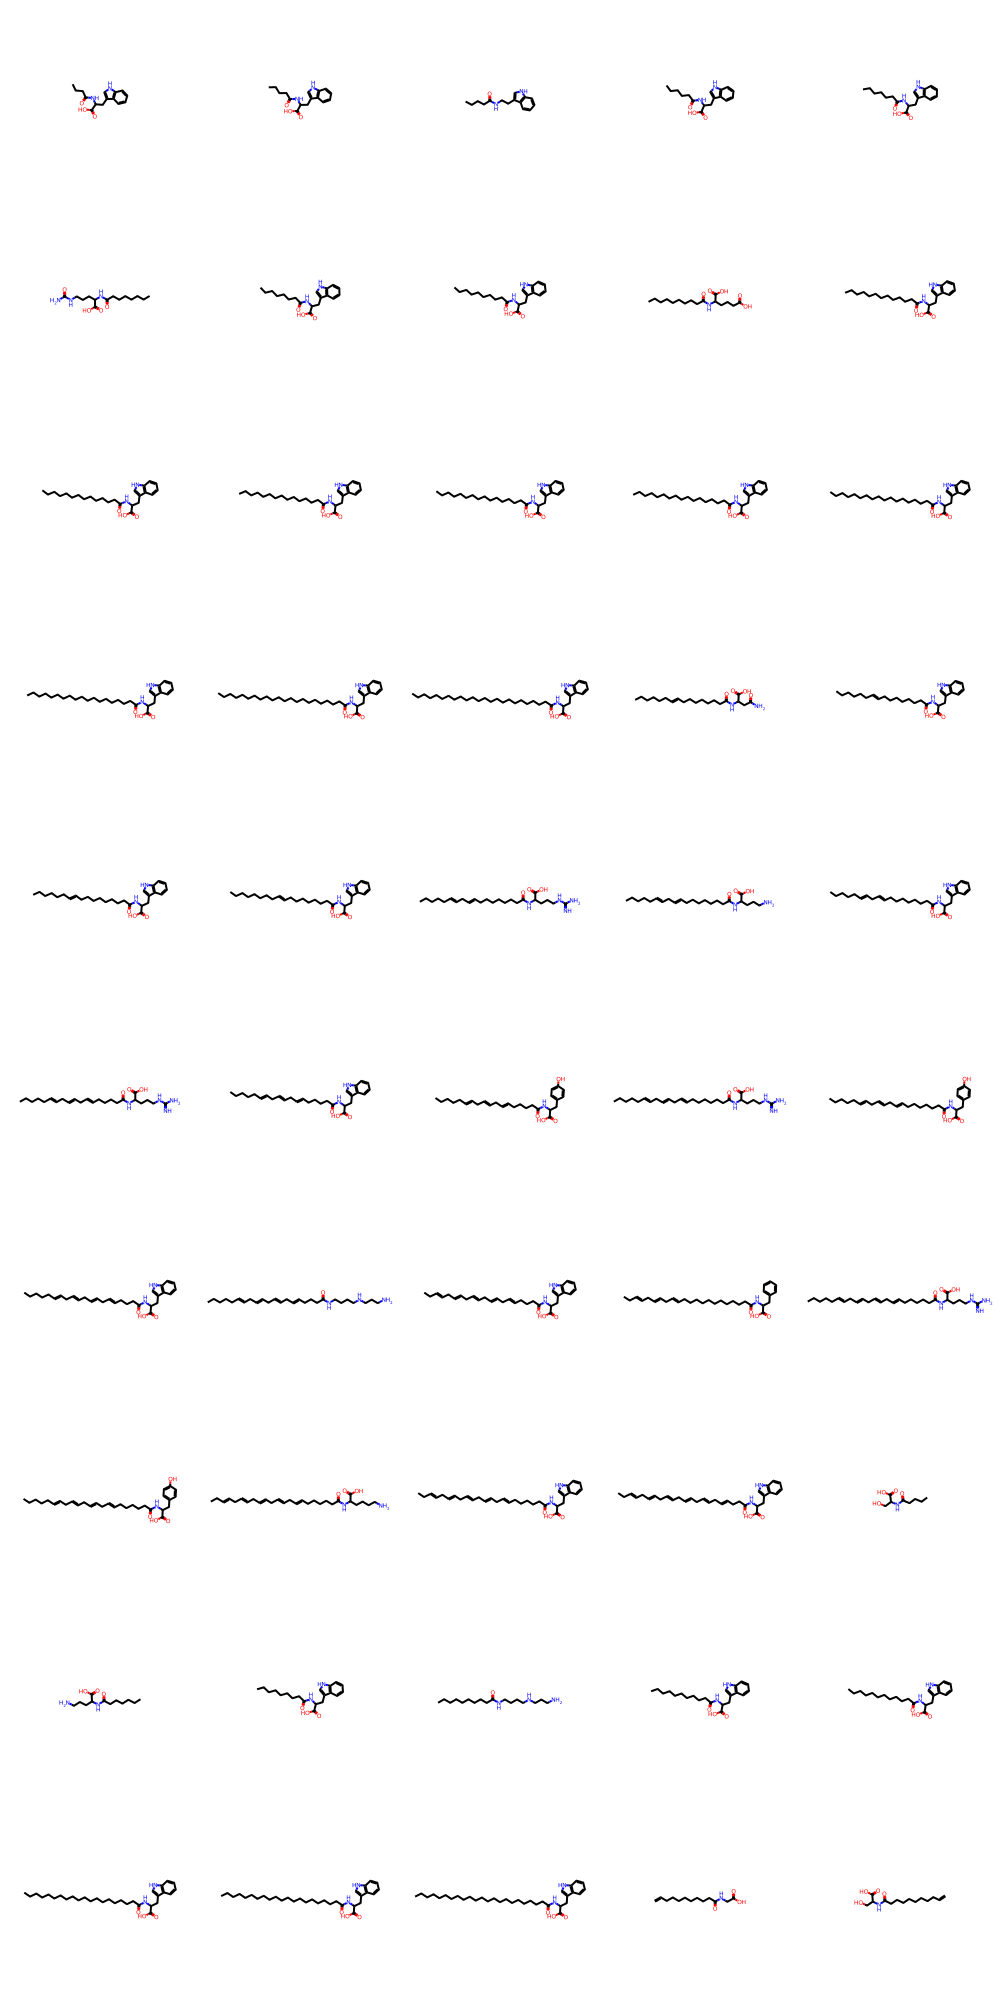

In [ ]:
MolsToGridImage([MolFromSmiles(D[k].get("smiles")) for k in range(len(D))], molsPerRow=5)

Level A, B, C, and D all look very similar in their result and all show good results. Be aware that the choosen dataset is focus on this kind of structures and therefore is it less overlap expected than in for example food samples.

> **_TIPP:_**  If you want to evaluate the goodness of a motif by looking at the false positive matches, do never use the same dataset for modeling and screening, since the model learnt the specifics of the dataset and it needs a new dataset to check if the generatlization for a substructures was successful. Similar to all machine learning methods.